In [352]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://memepedia.ru/wp-content/uploads/2020/05/ja-objazatelno-vyzhivu-original-s-kotenkom.jpg", width=500, height=1000)

In [1]:
import numpy as np
import matplotlib.pylab as plt

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from math import floor

import warnings
warnings.filterwarnings("ignore")

### Constants 1

In [241]:
gL = 0.003 * 1e2
gK = 0.36 * 1e2
gNa = 1.2 * 1e2

EL = -54.387
EK = -77
ENa = 50

total_time = 60000
timesteps = np.arange(0, total_time, 1)

### Constants 2

In [186]:
K_glu = 500 * 1e-9
K_gab = 128 * 1e-9

Y_glu = 10 * 1e-3
Y_gab = 8 * 1e-3

VCl = -65
VNa = 55

### Alphas and Betas

In [187]:
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65)) 

def beta_m(V):
    return 4 * np.exp(-0.0556 * (V + 65))

def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))

ALPHAS_BETAS = {
    'n': (alpha_n, beta_n),
    'm': (alpha_m, beta_m),
    'h': (alpha_h, beta_h)
}

In [188]:
class Distribution:
    def __init__(self, np_dist_type, dist_params, size):
        """
            :param   np_dist_type:  Numpy distribution class, eg. np.random.uniform
            :param    dist_params:  Parameters of distribution, dict
            :param           size:  Number of samples
        """
        self.np_dist_type = np_dist_type
        self.dist_params = dist_params
        self.size = size
    
    def sample(self):
        return self.np_dist_type(**self.dist_params, size=self.size)

In [268]:
class Synapse:
    def __init__(self, L_in, L_out, K_d, V_eq, volume, N, gamma, dist, timesteps):
        """
            :param   L_in:  Amount of incoming ligand
            :param  L_out:  Amount of outgoing ligand
            :param    K_d:  Dissociation constant
            :param   V_eq:  Equilibrium potential
            :param volume:  Volume of a synapse
            :param      N:  Number of receptors
            :param  gamma:  Receptor's conductance constant
            :param   dist:  Distribution
        """
        self.L_in = L_in
        self.L_out = L_out
        self.K_d = K_d
        self.V_eq = V_eq
        self.volume = volume
        self.N = N
        self.gamma = gamma
        self.L = 0
        
        self.dist = dist
        self.spike_time_samples = list(self.dist.sample())
        self.spike_timesteps = [0]
        for time_sample in self.spike_time_samples:
            ts = self.spike_timesteps[-1] + time_sample
            self.spike_timesteps.append(ts)
        self.spike_timesteps = self.spike_timesteps[1:]
        
        self.current_values = [self.calc_current(t) for t in timesteps]
        self.time_to_current = dict(zip(timesteps, self.current_values))
    
    def calc_current(self, t):
        if t in self.spike_timesteps:
            self.L += self.L_in
        self.L -= self.L_out
        self.L = min(self.volume, self.L)
        self.L = max(0, self.L)
        l = self.L / self.volume
        P = (l / self.K_d) / (1 + (l / self.K_d))
        return self.N * P * self.gamma
            
    def __call__(self, t):
        t = int(np.floor(t))
        if t not in self.time_to_current:
            return self.calc_current(t)
        return self.time_to_current[int(np.floor(t))]
    
    @property
    def V(self):
        return self.V_eq

In [337]:
class TwoSynapsesHHModel:
    def __init__(self, synapse_A, synapse_B, timesteps, Cm=1):
        """
            :param       synapse_A:  instance of a Synapse class
            :param       synapse_B:  instance of a Synapse class
            :param       timesteps:  timesteps array
        """
        self.synapse_A = synapse_A
        self.synapse_B = synapse_B
        self.timesteps = timesteps
        self.Cm = Cm
        self.init_conditions = (-65, 0.05, 0.6, 0.32)
    
    def dxdt(self, V, x_idx, x):
        """
            :param V: just V...
            :param x_idx: string, either 'n', 'm' or 'h'
            :param x: the value of n, m, or h
            :return: dxdt
        """
        alpha, beta = ALPHAS_BETAS[x_idx]
        return alpha(V) * (1 - x) - beta(V) * x
    
    def dVdt(self, V, timestep, n, m, h):
        IK = gK * (n**4) * (V - EK)
        INa = gNa * (m**3) * h * (V - ENa)
        I_synA = self.synapse_A(timestep) * (V - self.synapse_A.V)
        I_synB = self.synapse_B(timestep) * (V - self.synapse_B.V)
        return -1 / self.Cm * (IK + INa + I_synA + I_synB)
    
    def func_to_derivate(self, variables, timestep):
        V, n, m, h = variables
        return [
            self.dVdt(V, timestep, n, m, h),
            self.dxdt(V, 'n', n),
            self.dxdt(V, 'm', m),
            self.dxdt(V, 'h', h)
        ]
    
    def solve(self):
        return odeint(
            func = self.func_to_derivate, 
            y0   = self.init_conditions, 
            t    = self.timesteps
        )
    
    def get_currents(self, solution):
        V = solution[:, 0]
        n = solution[:, 1]
        m = solution[:, 2]
        h = solution[:, 3]
        IK = [0] * len(V)
        INa = [0] * len(V)
        I_synA = [0] * len(V)
        I_synB = [0] * len(V)
        for i, t in enumerate(self.timesteps):
            IK[i] = gK * (n[i]**4) * (V[i] - EK)
            INa[i] = gNa * (m[i]**3) * h[i] * (V[i] - ENa)
            I_synA[i] = self.synapse_A(t) * (V[i] - self.synapse_A.V)
            I_synB[i] = self.synapse_B(t) * (V[i] - self.synapse_B.V)
        return IK, INa, I_synA, I_synB

In [360]:
def computeHz(V):
    count = 0
    Hz = []
    prev_V = -100
    for ts, V_i in enumerate(V):
        if V_i > 0 and prev_V <= 0:
            count += 1
        if (ts + 1) % 1000 == 0:
            Hz.append(count)
            count = 0
        prev_V = V_i
    return Hz

### Synapse A

Volume and ligand amount

In [328]:
L_in_A = 1000
L_out_A = 200
volume_A = 1500
N_A = 100

Distribution

In [406]:
params_A = {
    'lam': 75
}

distribution_A = Distribution(
    np_dist_type = np.random.poisson,
    dist_params  = params_A,
    size         = total_time
)

In [407]:
synapse_A = Synapse(
    L_in      = L_in_A,
    L_out     = L_out_A,
    K_d       = K_glu,
    V_eq      = VCl,
    volume    = volume_A,
    N         = N_A,
    gamma     = Y_glu,
    dist      = distribution_A,
    timesteps = timesteps
)

### Synapse B

Volume and ligand amount

In [408]:
L_in_B = 1000
L_out_B = 600
volume_B = 1000
N_B = 100

Distribution

In [409]:
params_B = {
    'low': 0,
    'high': 160
}

distribution_B = Distribution(
    np_dist_type = np.random.randint,
    dist_params  = params_B,
    size         = total_time
)

In [410]:
synapse_B = Synapse(
    L_in      = L_in_B,
    L_out     = L_out_B,
    K_d       = K_gab,
    V_eq      = VNa,
    volume    = volume_B,
    N         = N_B,
    gamma     = Y_gab,
    dist      = distribution_B,
    timesteps = timesteps
)

### Model

In [411]:
model = TwoSynapsesHHModel(synapse_A, synapse_B, timesteps)

In [412]:
result = model.solve()

In [413]:
IK, INa, I_synA, I_synB = model.get_currents(result)

Text(0, 0.5, 'V $mV$')

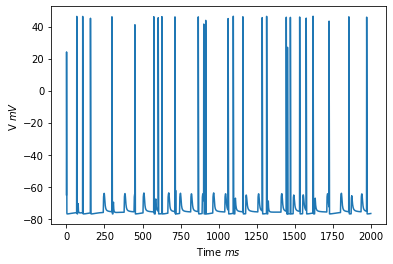

In [414]:
plt.plot(timesteps[:2000], result[:, 0][:2000])
plt.xlabel('Time $ms$')
plt.ylabel('V $mV$')
# print(result[:, 0])

#### I_synaptic for neuron "A"

Text(0, 0.5, 'I $nA$')

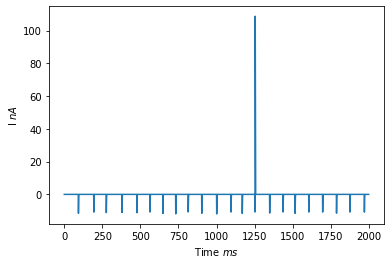

In [399]:
plt.plot(timesteps[:2000], I_synA[:2000])
plt.xlabel('Time $ms$')
plt.ylabel('I $nA$')

#### I_synaptic for neuron "B"

Text(0, 0.5, 'I $nA$')

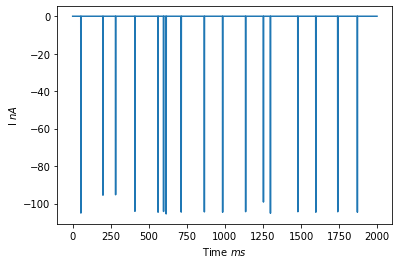

In [400]:
plt.plot(timesteps[:2000], I_synB[:2000])
plt.xlabel('Time $ms$')
plt.ylabel('I $nA$')

In [415]:
Hz_list = computeHz(result[:, 0])

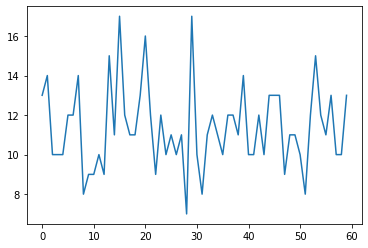

In [416]:
plt.plot(list(range(len(Hz_list))), Hz_list)

In [417]:
print(Hz_list)

[13, 14, 10, 10, 10, 12, 12, 14, 8, 9, 9, 10, 9, 15, 11, 17, 12, 11, 11, 13, 16, 12, 9, 12, 10, 11, 10, 11, 7, 17, 10, 8, 11, 12, 11, 10, 12, 12, 11, 14, 10, 10, 12, 10, 13, 13, 13, 9, 11, 11, 10, 8, 12, 15, 12, 11, 13, 10, 10, 13]


In [418]:
def viz2d(solution, I_syn_A, I_syn_B, timesteps):
    V = solution[:, 0]
    x_array = [(solution[:, 1], 'n', 'r'), (solution[:, 2], 'm', 'g'), (solution[:, 3], 'h', 'b')]
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(timesteps, V)
    ax1.set_ylabel('$V(mV)$', fontsize=14)
    ax1.set_xlabel('$t(ms)$', fontsize=14)
    
    for x in x_array:
        values, label, color = x
        ax2 = plt.subplot(3, 1, 2)
        ax2.plot(timesteps, values, label=label, color=color)
    ax2.set_ylabel('n, m, h', fontsize=14)
    ax2.set_xlabel('$t(ms)$', fontsize=14)
    ax2.legend(loc='lower right')
    
    ax3 = plt.subplot(3, 1, 3)
    ax3.plot(timesteps, current_values)
    ax3.set_ylabel('$i_m({\mu}A / mm^2)$', fontsize=14)
    ax3.set_xlabel('$t(ms)$', fontsize=14)

def viz3d(solution, current_values, timesteps):
    V = solution[:, 0]
    x_array = [(solution[:, 1], 'n', 'r'), (solution[:, 2], 'm', 'g'), (solution[:, 3], 'h', 'b')]
    
    fig = plt.figure(figsize=(18, 6))
    for i, x in enumerate(x_array):
        values, label, color = x
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.plot3D(timesteps, V, values, color=color)
        ax.set_xlabel('$t\ (ms)$', fontsize=14)
        ax.set_ylabel('$V(t)\ (mV)$', fontsize=14)
        ax.set_zlabel('$' + label + '(t)$', fontsize=14)

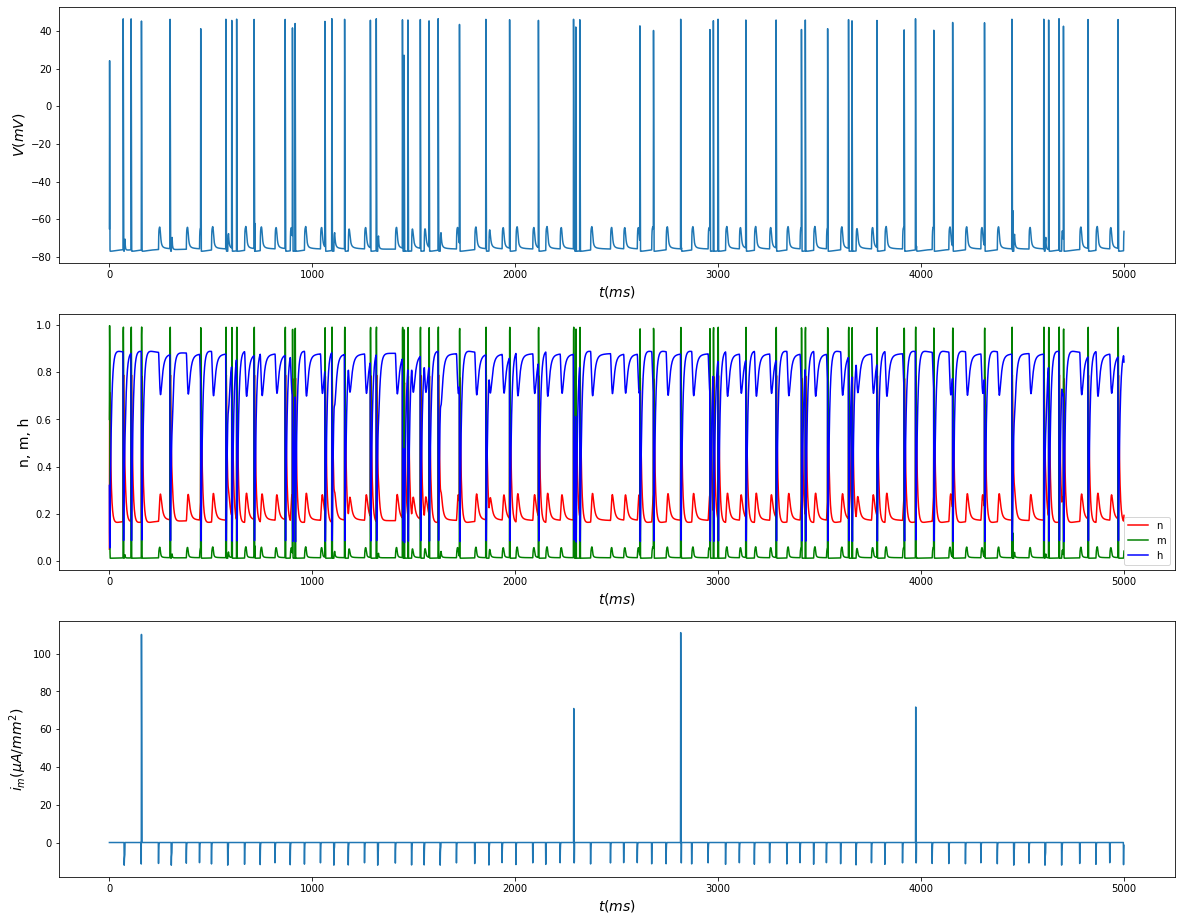

In [420]:
viz2d(result[:5000], I_synA[:5000], timesteps[:5000])